## Machine Learning Notebook for Compter Vision using PyTorch
`torchvision`: - base
`torchvision.datasets` - get datasets and data loading functions for computer vision
`torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
`torchvision.transofmrs` - functions for manipulating your vision data (images) to be suited for ML models
`torch.utils.data.Dataset` - base dataset class for PyTorch

In [12]:
# Import Pytorch
import torch
from torch import nn

# Import Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

## Dataset
FashionMNIST database: a database of pictures of clothes that's done in grayscale
Download is included by PyTorch (in datasets list)

In [2]:
train_data = datasets.FashionMNIST(
    root="data", # where does the downloaded data go to?
    train=True, # do we want the training dataset or testing dataset 
    download=True, #do we want to download
    transform=torchvision.transforms.ToTensor(), # how do we want to transofrm the data? ()
    target_transform=None # do we need to transform the labels (output)?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # this is the testing dataset, so no train
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Using downloaded and verified file: data\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw

Using downloaded and verified file: data\FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [35]:
class_names = train_data.classes # command to see information of the different classes of our train_data
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_dict = train_data.class_to_idx # same command as above but returns as a dictionary (class category paired with index)
class_dict

In [13]:
# Making a DataLoader
# A DataLoader turns a dataset (in this case images) into a Python iterable (batches / mini-batches of data sections)
from torch.utils.data import DataLoader

# set up a Batch Size HYPERPARAMATER
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

Image size: torch.Size([1, 28, 28])
Label: 4, label size: <built-in method size of Tensor object at 0x000001E34DE06EE0>


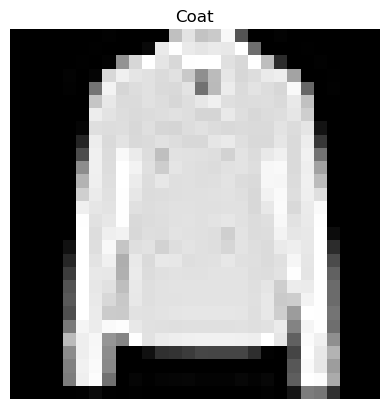

In [39]:
# SHOWING SAMPLES OF OUR MODEL'S DATA
randomIndex = torch.randint(0, len(train_features_batch), size=[1]).item() # visualize one random sample from our batch (BATCH_SIZE)
img, label = train_features_batch[randomIndex], train_labels_batch[randomIndex] # fetch the "image" and label from our batch at randomIndex
plt.imshow(img.squeeze(), cmap="gray") # displays the image (in grayscale)
plt.title(class_names[label]) # sets title to label string (since label is a tensor)
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.size}")

## MODEL 0: Linear MNIST Model that's trained on the CPU

#### Building a baseline comp. vision model

In [48]:
# create a flatten layer
flatten_model = nn.Flatten() # flattens the image tensor of our model from [1, 28, 28] to [1, 784]

# building the baseline model
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

# building the forward pass
    def forward(self, x):
        return self.layer_stack(x)

In [52]:
# Setting up an instance of our model

torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape = 784, # this is 28x28
    hidden_units=10,
    output_shape=len(class_names) # one output node for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

#### Create a loss function and optimizer
since we're working with multi-class data, loss function is `nn.CrossEntropyLoss()`

optimizer will still be `torch.optim.SGD()`

since we're working on a classification problem, we can use accuracy as an evaluation metric

In [54]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred)) * 100

In [55]:
# setup our loss and optimizer function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [57]:
# Code block that checks how fast the model runs
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

#### Creating a Training Loop and training the model (model 0)

In [60]:
# importing tkdm to make a simple and quick progress bar (check the github for more info)
from tqdm.auto import tqdm

# set seed and start timer
torch.manual_seed(42)
train_time_start_CPU = timer()

# setting the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    # Training loop
    train_loss = 0 # <- this is the TOTAL LOSS of ONE BATCH. will be devided to find the average loss per item
    # second loop to loop through training batches
    for batch, (image, label) in enumerate(train_dataloader): # for each loop that loops through the batch. enumerate lets us keep track of # of batches
        model_0.train()
        #Forward pass
        label_pred = model_0(image)

        #Calculate the loss
        loss = loss_fn(label_pred, label)
        train_loss += loss # accumulate the train loss

        #Optimizer zero grad
        optimizer.zero_grad()

        #Loss Backward
        loss.backward()

        #Optimizer step NOTE: OPTIMIZER WOULD OPTIMIZE AFTER EVERY BATCH (since it is in the batch loop), RATHER THAN AFTER VIEWING ALL DATA
        optimizer.step()

        # Printing out values
        if batch % 400 == 0:
            print(f"Viewed {batch * len(image)}/{len(train_dataloader.dataset)} samples.")

        # END OF BATCH LOOP
    
    #Divide total trian loss by length of train dataloader
    train_loss /= len(train_dataloader)

    #Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for image_test, label_test in test_dataloader:
            #Forward pass
            test_pred = model_0(image_test)

            #Calculate the loss (accumulatively)
            test_loss += loss_fn(test_pred, label_test)

            #Calculate accuracy
            test_acc += accuracy(y_true=label_test, y_pred=test_pred.argmax(dim=1)) # converting test_pred from logits to prediction labels (argmax)

        #Calculate the test loss and accuracy (avg value per batch)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        #END OF EVAL LOOP
    
    #Print out what's happening
    print(f"\nTraining loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

#Calculate the training time
train_time_end_CPU = timer()

total_time_CPU = print_train_time(start=train_time_start_CPU,
                                  end=train_time_end_CPU,
                                  device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Viewed 0/60000 samples.
Viewed 12800/60000 samples.
Viewed 25600/60000 samples.
Viewed 38400/60000 samples.
Viewed 51200/60000 samples.


 33%|███▎      | 1/3 [00:07<00:15,  7.88s/it]


Training loss: 0.4764 | Test loss: 0.4825, Test acc: 82.9972
Epoch: 1
---------
Viewed 0/60000 samples.
Viewed 12800/60000 samples.
Viewed 25600/60000 samples.
Viewed 38400/60000 samples.
Viewed 51200/60000 samples.


 67%|██████▋   | 2/3 [00:15<00:07,  7.70s/it]


Training loss: 0.4556 | Test loss: 0.4725, Test acc: 83.6262
Epoch: 2
---------
Viewed 0/60000 samples.
Viewed 12800/60000 samples.
Viewed 25600/60000 samples.
Viewed 38400/60000 samples.
Viewed 51200/60000 samples.


100%|██████████| 3/3 [00:22<00:00,  7.66s/it]


Training loss: 0.4436 | Test loss: 0.4714, Test acc: 83.5763
Train time on cpu: 22.972 seconds


#### Making predictions and get results of Model 0

In [64]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,    # defining a custom function and defining parameters to be passed in
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary contraining the results of mdoel predicting on data_loader."""
    loss, acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        # Batch loop
        for image, label in data_loader:
            # make prediction
            label_pred = model(image)

            # Accumulate the loss and accuracy val per batch
            loss += loss_fn(label_pred, label)
            acc += accuracy_fn(y_true=label,
                               y_pred=label_pred.argmax(dim=1))
            # END BATCH LOOP
        # find average loss and acc per batch (len(data_loader) = # of items per batch)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works if models are created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [65]:
# calculate model results on test data

model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47143012285232544,
 'model_acc': 83.57627795527156}

## MODEL 1: NONlinear MNIST Model that's trained on the GPU
this model also borrows some things from Model0

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [77]:
torch.cuda.is_available()

False

In [82]:
# Creating a model with non-linear & linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units,),
            nn.ReLU(),  # NON LINEAR LAYER TYPE (relu)
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [85]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784,
                              hidden_units=10,
                              output_shape = len(class_names)).to(device)


In [ ]:
# instantiate a loss and optimizer function.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)
